# Example of analyzing a neural feedback loop

## Load libraries and set random seed

In [1]:
import numpy as np
import nn_closed_loop.dynamics as dynamics
import nn_closed_loop.analyzers as analyzers
import nn_closed_loop.constraints as constraints
from nn_closed_loop.utils.nn import load_controller, load_controller_unity
from nn_closed_loop.utils.utils import range_to_polytope, get_polytope_A

In [2]:
np.random.seed(seed=0)

## Load NN control policy, $\pi$

In [3]:
controller = load_controller(name="double_integrator")
print(controller)

Sequential(
  (0): Linear(in_features=2, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=5, bias=True)
  (3): ReLU()
  (4): Linear(in_features=5, out_features=1, bias=True)
)


## Load dynamics model (double integrator), $\mathbf{x}_{t+1} = f(\mathbf{x}_t; \pi)$

In [4]:
dyn = dynamics.DoubleIntegrator()
print(dyn)

## Define initial state set, $\mathcal{X}_0$

In [5]:
# Note: this notebook uses $\ell_infty$-ball sets
init_state_range = np.array(
    [  # (num_inputs, 2)
        [2.5, 3.0],  # x0min, x0max
        [-0.25, 0.25],  # x1min, x1max
    ]
)

# Convert these into constraint objects
input_constraint = constraints.LpConstraint(
    range=init_state_range, p=np.inf
)
output_constraint = constraints.LpConstraint(p=np.inf)
print(input_constraint)

## Define partitioner hyperparameters

In [6]:
partitioner_hyperparams = {
    "type": "GreedySimGuided",
    "make_animation": False,
    "show_animation": False,
}

## Define propagator hyperparameters

In [7]:
propagator_hyperparams = {
    "type": "CROWN",
    "input_shape": init_state_range.shape[:-1],
}

## Initialize analyzer, partitioner, propagator

In [8]:
analyzer = analyzers.ClosedLoopAnalyzer(controller, dyn)
analyzer.partitioner = partitioner_hyperparams
analyzer.propagator = propagator_hyperparams
print(analyzer)

## Compute the reachable sets

In [9]:
t_max = 5
output_constraint, analyzer_info = analyzer.get_reachable_set(
    input_constraint, output_constraint, t_max=t_max
)
print(output_constraint.range)
# analyzer_info contains more details

[[[ 1.90837383  2.75      ]
  [-1.125      -0.70422709]]

 [[ 1.01761031  1.8305043 ]
  [-1.10589671 -0.80364925]]

 [[ 0.36083901  0.94537741]
  [-0.76938218 -0.41734082]]

 [[ 0.01732248  0.42632043]
  [-0.41059628 -0.14207691]]

 [[-0.21241173  0.24513718]
  [-0.21547571 -0.0169901 ]]]


## Generate a visualization of the input/output mapping

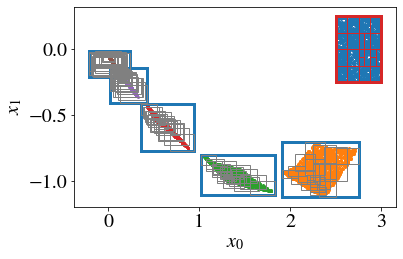

In [10]:
analyzer.visualize(
    input_constraint,
    output_constraint,
    show_samples=True,
    show=True,
    labels=None,
    aspect="auto",
    iteration=None,
    inputs_to_highlight=[{"dim": [0], "name": "$x_0$"}, {"dim": [1], "name": "$x_1$"}],
    **analyzer_info
)

## Estimate the output set error

In [11]:
final_error, avg_error, errors = analyzer.get_error(input_constraint, output_constraint, t_max=t_max)
print('Final step approximation error: {:.2f}'.format(final_error))
print('Average approximation error: {:.2f}'.format(avg_error))
print('All errors: {}'.format(errors))

Final step approximation error: 19.02
Average approximation error: 4.54
All errors: [ 0.24167679  0.38787424  0.65314041  2.40027115 19.01889623]
